# Comparing a USGSCSM and ISIS camera for Kaguya Terrain Camera

In [1]:
import pvl
import os
import tempfile
import csmapi
import json

os.environ['ISISROOT'] = '/usgs/pkgs/isis3.8.0_RC1/install'
import knoten
import ale
from knoten import vis
from ale.drivers.kaguya_drivers import KaguyaTcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm
from ale import util
from IPython.display import Image
from pysis import isis
from pysis.exceptions import ProcessError

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Make a CSM sensor model
Requires TC1S2B0_01_02842S506E1942.img in data directory

In [2]:
fileName = 'data/TC1S2B0_01_02842S506E1942.img'
camera = knoten.csm.create_csm(fileName)

## Ingest the image and spiceinit

In [3]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.kaguyatc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')#, iak='/home/arsanders/testData/kaguyaTcAddendum007.ti')
except ProcessError as e:
    print(e.stderr)

with KaguyaTcPds3NaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)

    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))

## Compare USGS CSM and ISIS pixels

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

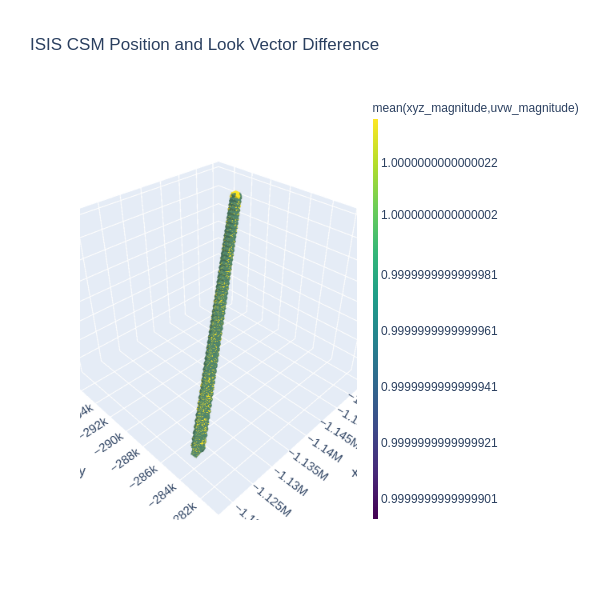

In [7]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

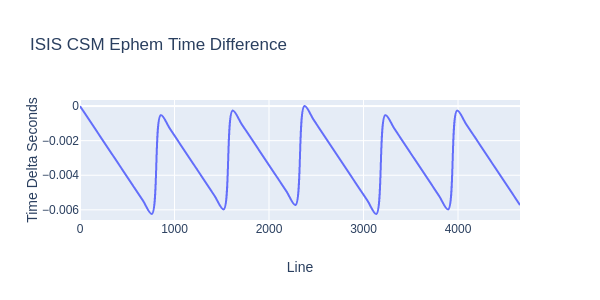

In [8]:
Image(csmisis_diff_ephem_plot_bytes)

In [9]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-70.298353,-18.115809,-62.592774,0.092389,0.025630,-0.169494
std,2.338138,0.647899,2.026424,0.001315,0.000957,0.000795
min,-75.209237,-19.471415,-66.143944,0.089742,0.023617,-0.171069
25%,-71.762435,-18.529616,-64.437338,0.091270,0.024856,-0.170148
50%,-70.029134,-18.035598,-62.649173,0.092398,0.025662,-0.169491
75%,-68.290971,-17.547047,-60.887290,0.093511,0.026411,-0.168832
max,-65.569093,-16.813671,-59.214698,0.094784,0.027522,-0.167702


In [10]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

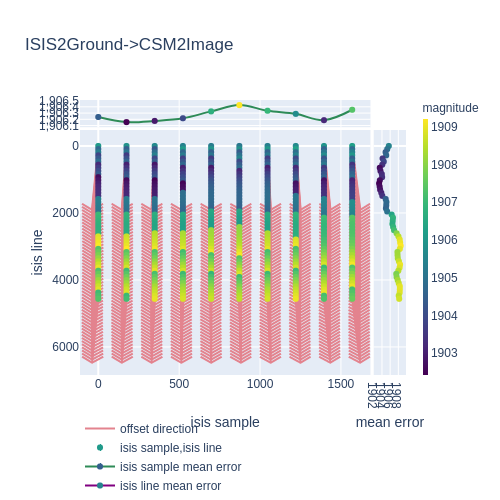

In [11]:
Image(isis2csm_plot.to_image())

In [12]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,1906.058078,4.841694
std,1.936312,28.032562
min,1902.213384,-40.510825
25%,1904.513242,-19.389748
50%,1906.391421,4.471773
75%,1907.865304,29.284922
max,1909.137085,50.390504


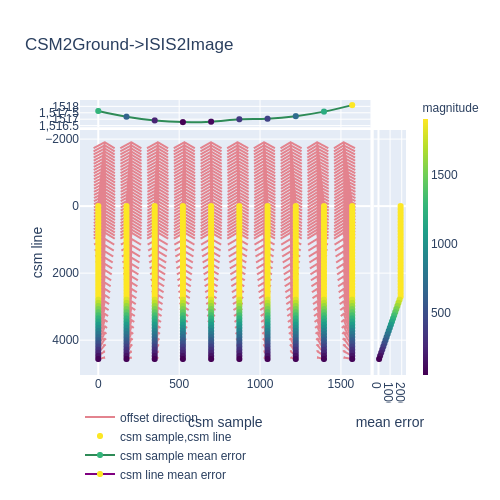

In [13]:
Image(csm2isis_plot.to_image())

In [14]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-1516.632930,-4.787920
std,587.539847,29.564615
min,-1909.114526,-52.856050
25%,-1907.926712,-31.063513
50%,-1906.517471,-4.530378
75%,-1163.094623,20.290581
max,-45.465005,42.867196


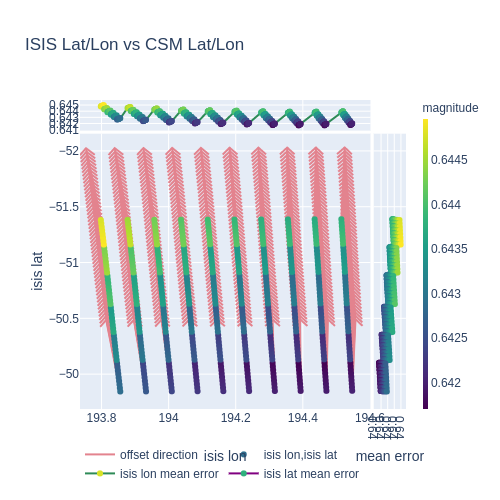

In [15]:
Image(isiscsm_plotlatlon.to_image())

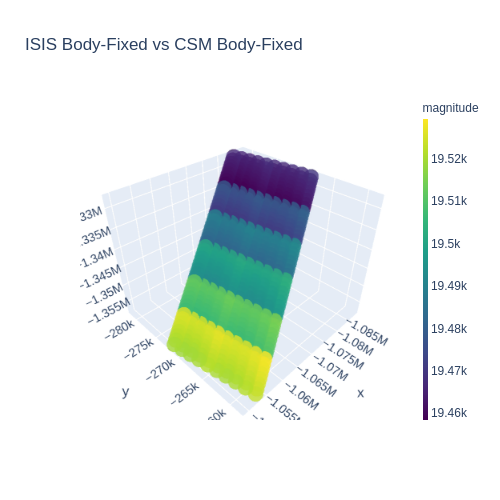

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,1.886635,-4013.755576,12279.626096
std,0.019270,255.049494,107.382675
min,1.849634,-4453.900028,12088.517979
25%,1.870359,-4233.546832,12189.156000
50%,1.886819,-4015.308982,12280.050193
75%,1.902861,-3795.797088,12374.149160
max,1.923804,-3569.385064,12468.505932
